# IST 718: Big Data Analytics

- Professor: Daniel Acuna <deacuna@syr.edu>

## General instructions:

- You are welcome to discuss the problems with your classmates but __you are not allowed to copy any part of your answers either from your classmates or from the internet__
- You can put the homework files anywhere you want in your https://jupyterhub.ischool.syr.edu/ workspace but _do not change_ the file names. The TAs and the professor use these names to grade your homework.
- Remove or comment out code that contains `raise NotImplementedError`. This is mainly to make the `assert` statement fail if nothing is submitted.
- The tests shown in some cells (i.e., `assert` and `np.testing.` statements) are used to grade your answers. **However, the professor and TAs will use __additional__ test for your answer. Think about cases where your code should run even if it passess all the tests you see.**
- Before downloading and submitting your work through Blackboard, remember to save and press `Validate` (or go to 
`Kernel`$\rightarrow$`Restart and Run All`). 
- Good luck!

In [1]:
# Load the packages needed for this part
# create spark and sparkcontext objects
from pyspark.sql import SparkSession
import numpy as np

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

from pyspark.ml import feature, regression, Pipeline, pipeline, evaluation, tuning, clustering
from pyspark.sql import types, Row, functions as fn
from pyspark import sql
import pandas as pd
import matplotlib.pyplot as plt

# Part 2: Feature engineering and recommendation
In this project, we are going to study a dataset of Spotify songs for which we have a number of features.

In [2]:
spotify = spark.read.csv('spotify_songs.csv', header=True, inferSchema=True)

In [3]:
spotify.limit(5).toPandas()

,song_title,artist,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Mask Off,Future,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286
1,Redbone,Childish Gambino,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588
2,Xanny Family,Future,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173
3,Master Of None,Beach House,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230
4,Parallel Lines,Junior Boys,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904


## Question 1. (10 pts)
First, we will try to understand how the duration, tempo, and key are related to danceability. Unfortunately, each of these features is in different scales, and the feature key is categorical.

Create a pipeline model (i.e., fitted pipeline) called `featurize` that performs the following feature engineering steps
- Standardizes `duration_ms` and `tempo` (you have to combine `feature.VectorAssembler` with `feature.StandardScaler`)
- Create dummy variables for `key` (you have to use `feature.OneHotEncoder`. This encoder uses the *last category* as the baseline. Be careful when interpreting it)

You have to create a last step in this featurizer that combines the two kinds of engineered features into a column called `features` 

In [4]:
# create pipeline to produce principal components of data
# YOUR CODE HERE

featurize = Pipeline(stages = [
    feature.VectorAssembler(inputCols=['duration_ms','tempo'], outputCol='dur_tempo'),
    feature.StandardScaler(inputCol='dur_tempo', outputCol='dur_tempo_norm' ),
    feature.OneHotEncoder(inputCol='key', outputCol='key_OHE'),
    feature.VectorAssembler(inputCols=['dur_tempo_norm','key_OHE'], outputCol='features')
]).fit(spotify)


In [5]:
# test the featurizer here
featurize.transform(spotify).select('features').first().features.toArray()

array([2.49459311, 5.6247302 , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])

In [6]:
# 10 pts
assert type(featurize) == pipeline.PipelineModel
assert feature.StandardScalerModel in list(map(type, featurize.stages))
assert feature.OneHotEncoderModel in list(map(type, featurize.stages))
assert feature.VectorAssembler in list(map(type, featurize.stages))
assert len(featurize.transform(spotify).select('features').first().features.toArray()) == 13

## Question 2: (20 pts)
We will now compare a model without feature engineering to one with feature engineering.

First, create a vanilla pipeline model (i.e., fitted pipeline) that takes `duration_ms`, `tempo`, and `key` without any feature engineering and assembles them into a column `features`. Call this pipeline `vanilla_features`

In [7]:
# create pipeline for vanilla featurizer
# YOUR CODE HERE

vanilla_features = Pipeline(stages=[
    feature.VectorAssembler(inputCols=['duration_ms','tempo','key'], outputCol='features')
]).fit(spotify)


In [8]:
# test your pipeline
vanilla_features.transform(spotify).first().features.toArray()

array([2.04600e+05, 1.50062e+02, 2.00000e+00])

In [9]:
# 5 pts
assert type(vanilla_features) == pipeline.PipelineModel
assert len(vanilla_features.transform(spotify).select('features').first().features.toArray()) == 3

Now, create two regression pipeline estimators (don't fit them) `model_fe` and `model_vanilla` where `model_fe` uses the featurizer from Question 1 to create the features and `model_vanilla` creates the features using the previous pipeline. Remember that you are predicting `danceability`.

In [10]:
# create pipeline for models
# YOUR CODE HERE

model_fe = Pipeline(stages=[
    featurize,
    regression.LinearRegression(featuresCol='features', labelCol='danceability')
])

model_vanilla = Pipeline(stages=[
    vanilla_features,
    regression.LinearRegression(featuresCol='features', labelCol='danceability')
])

In [11]:
# 5 pts
assert type(model_fe) == pipeline.Pipeline
assert len(model_fe.getStages()) == 2
assert type(model_vanilla) == pipeline.Pipeline
assert len(model_vanilla.getStages()) == 2

With the code below, we will evaluate the performance of each of the models and print them

In [12]:
regression_evaluator = evaluation.RegressionEvaluator(labelCol='danceability', metricName='rmse')
training_df, validation_df = spotify.randomSplit([0.8, 0.2], seed=0)

print("RMSE model_fe: ", regression_evaluator.evaluate(model_fe.fit(training_df).transform(validation_df)))
print("RMSE model_vanilla: ", regression_evaluator.evaluate(model_vanilla.fit(training_df).transform(validation_df)))

RMSE model_fe:  0.16062889324651228
RMSE model_vanilla:  0.1609551207566255


**(10 pts)** Based on the results above, what can you say about the model with feature engineering. Is there are big difference in performance? If not, why would it be worth doing feature engineering anyway? Answer below

Since we are only evaluating linear regression models, it does not matter if the data is normalized. Performance of the model doesn't change, but you should still normalize features so you can interpret the results. Regressions produce coefficients that are only comparable when their inputs are normalized. 

## Question 3: (25 pts) Clustering

We will now make recommendation of songs based on k-means. Create a pipeline where you fit a 10-cluster KMeans to the following features **after standardization**

In [13]:
feature_list = ['acousticness',
 'danceability',
 'duration_ms',
 'energy',
 'instrumentalness',
 'key',
 'liveness',
 'loudness',
 'mode',
 'speechiness',
 'tempo',
 'time_signature',
 'valence']

Name the pipeline `spotify_clustering` and make sure that the `KMeans` model has a prediction column called `cluster`

In [14]:
# create pipeline spotify_clustering
# YOUR CODE HERE

spotify_clustering = Pipeline(stages=[
    feature.VectorAssembler(inputCols=feature_list, outputCol='feature_vecs'),
    feature.StandardScaler(inputCol='feature_vecs', outputCol='features_norm'),
    clustering.KMeans(k=10, featuresCol='features_norm', predictionCol='cluster')
    ]).fit(spotify)

In [15]:
# 10 pts
assert type(spotify_clustering) == pipeline.PipelineModel
assert feature.StandardScalerModel in set(map(type, spotify_clustering.stages))
assert spotify_clustering.stages[-1].extractParamMap()[(spotify_clustering.stages[-1].k)] == 10
assert spotify_clustering.stages[-1].extractParamMap()[(spotify_clustering.stages[-1].predictionCol)] == 'cluster'

As you all know, the professor is a big fan of Meat Loaf (the artists, obviously) and his song "I will do anything for love (But I won't do that)" because it is close to the professor's mantra: "I will do anything for data (But I won't overfit)".

In [16]:
meat_loaf = spotify.where(fn.col('artist') == "Meat Loaf")
print(meat_loaf.first().song_title)

I'd Do Anything For Love (But I Won't Do That)


In the cell below, extract the cluster number of Meat Loaf's song and store it in `meat_loaf_cluster_id`. Also, create a Spark DataFrame `similar_songs` with the songs from that Meat Loaf's cluster.

In [17]:
# create variable meat_loaf_cluster_id and dataframe similar_songs
# YOUR CODE HERE

predictions = spotify_clustering.transform(spotify)

meat_loaf_cluster_id = predictions.where(fn.col('artist') == 'Meat Loaf').first().cluster

similar_songs = predictions.where(fn.col('cluster') == 9)


In [18]:
# use the following code to find suggestions
similar_songs.select('song_title', 'artist').limit(10).toPandas()

,song_title,artist
0,Girlfriend,Ty Segall
1,Speakerbox (feat. Lafa Taylor),Bassnectar
2,Don't Wanna Lose,Ex Hex
3,Trust Me Danny,ILoveMakonnen
4,Fame (2007 Remastered),David Bowie
5,Weight,Mikal Cronin
6,Rocking Chair,The Districts
7,All These Things That I've Done,The Killers
8,Unbound,Cathedrals
9,Blood On The Leaves,Kanye West


In [19]:
# 10 pts
assert 0 <= meat_loaf_cluster_id <= 9
assert similar_songs.count() < spotify.count()
assert similar_songs.where('cluster == 0')
assert similar_songs.where('cluster = ' + str(meat_loaf_cluster_id)).where('artist = "Meat Loaf"').count() == 1

AssertionError: 

One of the problems wih `KMeans` is that clusters are sometimes unbalanced. Analyze the clustering by creating a dataframe `cluster_analysis` where the first column is the cluster (`cluster`) and the second is the number of song for such cluster (`n_songs`).

In [20]:
# create dataframe cluster_analysis
# YOUR CODE HERE

cluster_analysis = predictions.groupBy('cluster').count().withColumnRenamed('count','n_songs')
cluster_analysis.show()

+-------+-------+
|cluster|n_songs|
+-------+-------+
|      1|     92|
|      6|    134|
|      3|    248|
|      5|    150|
|      9|    252|
|      4|    336|
|      8|     72|
|      7|    175|
|      2|     85|
|      0|    465|
+-------+-------+



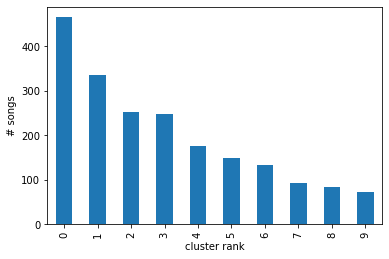

In [21]:
# plot the results
(cluster_analysis
 .toPandas()
 .sort_values('n_songs', ascending=False)
 .reset_index()
 .n_songs.plot(y='n_songs', kind='bar')
);
plt.xlabel('cluster rank')
plt.ylabel('# songs');

In [23]:
# 5 pts
assert cluster_analysis.count() == 10
assert type(cluster_analysis) == sql.dataframe.DataFrame